In [1]:
using Geant4
using Geant4.SystemOfUnits
using FHist, Printf, Plots

In [2]:
#---Define Detector Parameters struct--------------------------------------------------------------
include(joinpath(@__DIR__, "DetectorTestEm3.jl"))

In [3]:
#---Define Simulation Data struct------------------------------------------------------------------
mutable struct TestEm3SimData <: G4JLSimulationData
    #---Run data-----------------------------------------------------------------------------------
    fParticle::CxxPtr{G4ParticleDefinition}
    fEkin::Float64

    fEtotal::Float64
    fEtotal2::Float64
    
    fEnergyFlow::Vector{Float64}
    fLateralEleak::Vector{Float64}
    
    fChargedStep::Int32
    fNeutralStep::Int32

    fN_gamma::Int32
    fN_elec::Int32
    fN_pos::Int32

    fEnergyDeposit::Vector{Float64}     # Energy deposit per event
    fTrackLengthCh::Vector{Float64}     # Track length per event

    fEdepEventHistos::Vector{Hist1D}
    fTrackLengthChHistos::Vector{Hist1D}
    fEdepHistos::Vector{Hist1D}
    fAbsorLabel::Vector{String}

    fTimer::Float64

    TestEm3SimData() = new()
end

In [4]:
#---Plot the Sumulation data-----------------------------------------------------------------------
function do_plot(data::TestEm3SimData)
    (;fEdepHistos, fEdepEventHistos, fTrackLengthChHistos, fAbsorLabel) = data
    lay = @layout [°; ° °]
    p = plot(layout=lay, show=true, size=(1000,800))
    for (h, l) in zip(fEdepHistos, fAbsorLabel)
        plot!(subplot=1, h, title="Energy Deposition", xlabel="layer #", label=l, show=true)
    end
    for (h, l) in zip(fEdepEventHistos, fAbsorLabel)
        plot!(subplot=2, h, title="Energy/event Distribution", label=l, xlabel="MeV")
    end
    for (h, l) in zip(fTrackLengthChHistos, fAbsorLabel)
        plot!(subplot=3, h, title="Track Lengh Distribution", label=l, xlabel="mm")
    end
    p
end

do_plot (generic function with 1 method)

In [5]:
#---Particle Gun initialization--------------------------------------------------------------------
function gun_initialize(gen::G4JLParticleGun, det::G4JLDetector)
    pg = GetGun(gen)
    SetParticleByName(pg, "e-")
    SetParticleEnergy(pg, 1GeV)
    SetParticleMomentumDirection(pg, G4ThreeVector(1,0,0))
    SetParticlePosition(pg, G4ThreeVector(-0.5 * det.fWorldSizeX, 0 , 0))
  end
  Geant4.getInitializer(::G4JLParticleGun) = gun_initialize

In [6]:
#--------------------------------------------------------------------------------------------------
#----Actions---------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#---Step action------------------------------------------------------------------------------------
function stepaction(step::G4Step, app::G4JLApplication)::Nothing
    data = app.simdata
    detector = app.detector
    prepoint = GetPreStepPoint(step)
    endPoint = GetPostStepPoint(step)
    track = GetTrack(step)
 
    # Return if step in not in the world volume
    prepoint |> GetPhysicalVolume |> GetLogicalVolume |> GetMaterial == detector.fWorldMaterial && return nothing
 
    particle = GetDefinition(track)
    charge  = GetPDGCharge(particle)
    stepl = 0.
    if charge != 0.
        stepl = GetStepLength(step)
        data.fChargedStep += 1
    else
        data.fNeutralStep += 1
    end
    edep = GetTotalEnergyDeposit(step) * GetWeight(track)
    absorNum  = GetCopyNumber(GetTouchable(prepoint), 0)
    layerNum  = GetCopyNumber(GetTouchable(prepoint), 1) + 1  # replicas copynumber starts at 0

    data.fEnergyDeposit[absorNum] += edep
    data.fTrackLengthCh[absorNum] += stepl 	

    push!(data.fEdepHistos[absorNum], layerNum, edep)
    nothing
end

#---Tracking pre-action----------------------------------------------------------------------------
let G4Gamma, G4Electron, G4Positron, first=true
global function pretrackaction(track::G4Track, app::G4JLApplication)::Nothing
    if first
        G4Gamma    = FindParticle("gamma")
        G4Electron = FindParticle("e-")
        G4Positron = FindParticle("e+")
        first = false
    end
    data = app.simdata
    d = GetDefinition(track)
    if d === G4Gamma 
        data.fN_gamma += 1
    elseif d === G4Electron
        data.fN_elec +=1
    elseif d === G4Positron
        data.fN_pos += 1
    end
    nothing
end
end
#---Tracking post-action---------------------------------------------------------------------------
function posttrackaction(track::G4Track, ::G4JLApplication)::Nothing
  nothing
end
#---Begin Run Action-------------------------------------------------------------------------------
function beginrun(run::G4Run, app::G4JLApplication)::Nothing
    data = app.simdata
    (; fNbOfAbsor, fNbOfLayers, fAbsorMaterial, fAbsorThickness) = app.detector
    gun = GetGun(app.generator)
    data.fParticle = GetParticleDefinition(gun)
    data.fEkin = GetParticleEnergy(gun)
    data.fN_gamma = data.fN_elec = data.fN_pos = 0
    data.fChargedStep = data.fNeutralStep = 0
    # init arrays
    #data.fEnergyDeposit = zeros(fNbOfAbsor, fNbOfLayers)
    data.fEdepHistos = [Hist1D(Float64; bins=0.:1.0:fNbOfLayers) for i in 1:fNbOfAbsor]
    data.fEdepEventHistos = [Hist1D(;bins=0:10:1000) for i in 1:fNbOfAbsor]
    data.fTrackLengthChHistos = [Hist1D(;bins=0:20:2000) for i in 1:fNbOfAbsor]
    data.fAbsorLabel = ["$(fAbsorThickness[i])mm of $(fAbsorMaterial[i] |> GetName |> String)" for i in 1:fNbOfAbsor]
    nothing
end
#---End Run Action---------------------------------------------------------------------------------
function endrun(run::G4Run, app::G4JLApplication)::Nothing
    data = app.simdata
    nEvt = GetNumberOfEvent(run)
    norm = nEvt > 0 ? 1/nEvt : 1.

    @printf "------------------------------------------------------------\n"
    @printf " Beam particle %s E = %.2f GeV\n" String(GetParticleName(data.fParticle)) data.fEkin/GeV 
    @printf " Mean number of gamma          %.2f\n" data.fN_gamma*norm 
    @printf " Mean number of e-             %.2f\n" data.fN_elec*norm 
    @printf " Mean number of e+             %.2f\n" data.fN_pos*norm 
    @printf " Mean number of charged steps  %f\n"   data.fChargedStep*norm 
    @printf " Mean number of neutral steps  %f\n"   data.fNeutralStep*norm 
    @printf "------------------------------------------------------------"
end
#---Begin Event Action-----------------------------------------------------------------------------
function beginevent(evt::G4Event, app::G4JLApplication)
    data = app.simdata
    (; fNbOfAbsor, fNbOfLayers) = app.detector
    data.fEnergyDeposit = zeros(fNbOfAbsor)
    data.fTrackLengthCh = zeros(fNbOfAbsor)
    nothing
end
#---End Event Action-------------------------------------------------------------------------------
function endevent(evt::G4Event, app::G4JLApplication)
    data = app.simdata
    (; fNbOfAbsor, fNbOfLayers) = app.detector
    for i in 1:fNbOfAbsor
        push!(data.fEdepEventHistos[i], data.fEnergyDeposit[i])
        push!(data.fTrackLengthChHistos[i], data.fTrackLengthCh[i])
    end
    nothing
end


endevent (generic function with 1 method)

In [7]:
#---Create the Application-------------------------------------------------------------------------
app = G4JLApplication(TestEm3Detector(),                          # detector with 'default' parameters
                      simdata = TestEm3SimData(),                 # simulation data structure
                      runmanager_type = G4RunManager,             # what RunManager to instantiate
                      physics_type = FTFP_BERT,                   # what physics list to instantiate
                      generator_type = G4JLParticleGun,           # what primary generator to instantiate
                      stepaction_method = stepaction,             # step action method
                      pretrackaction_method = pretrackaction,     # pre-tracking action
                      posttrackaction_method = posttrackaction,   # post-tracking action
                      beginrunaction_method=beginrun,             # begin-run action
                      endrunaction_method=endrun,                 #                  
                      begineventaction_method=beginevent,
                      endeventaction_method=endevent
                      )
              
#---Configure, Initialize and Run------------------------------------------------------------------                      
configure(app)
initialize(app)
ui = G4UImanager!GetUIpointer()
#ApplyCommand(ui, "/tracking/verbose 1")
beamOn(app, 1000)


**************************************************************
 Geant4 version Name: geant4-11-01-patch-01 [MT]   (10-February-2023)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: FTFP_BERT

Building Geometry now!!!



 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
======                 Electromagnetic Physics Parameters      ========
LPM effect enabled                                 1
Enable creation and use of sampling tables         0
Apply cuts on all EM processes                     0
Use combined TransportationWithMsc                 Disabled
Use general process                                1
Enable linear polarisation for gamma               0
Enable photoeffect sampling below K-shell          1
Enable sampling of quantum entanglement            0
X-section factor for integral approach             0.8
Min kinetic energy for tables                      100 eV 
Max kinetic energy for tables                      100 TeV
Number of bins per decade of a table               7
Verbose 

 Mean number of gamma          522.24
 Mean number of e-             896.46
 Mean number of e+             53.58
 Mean number of charged steps  3727.923000
 Mean number of neutral steps  3714.849000
------------------------------------------------------------

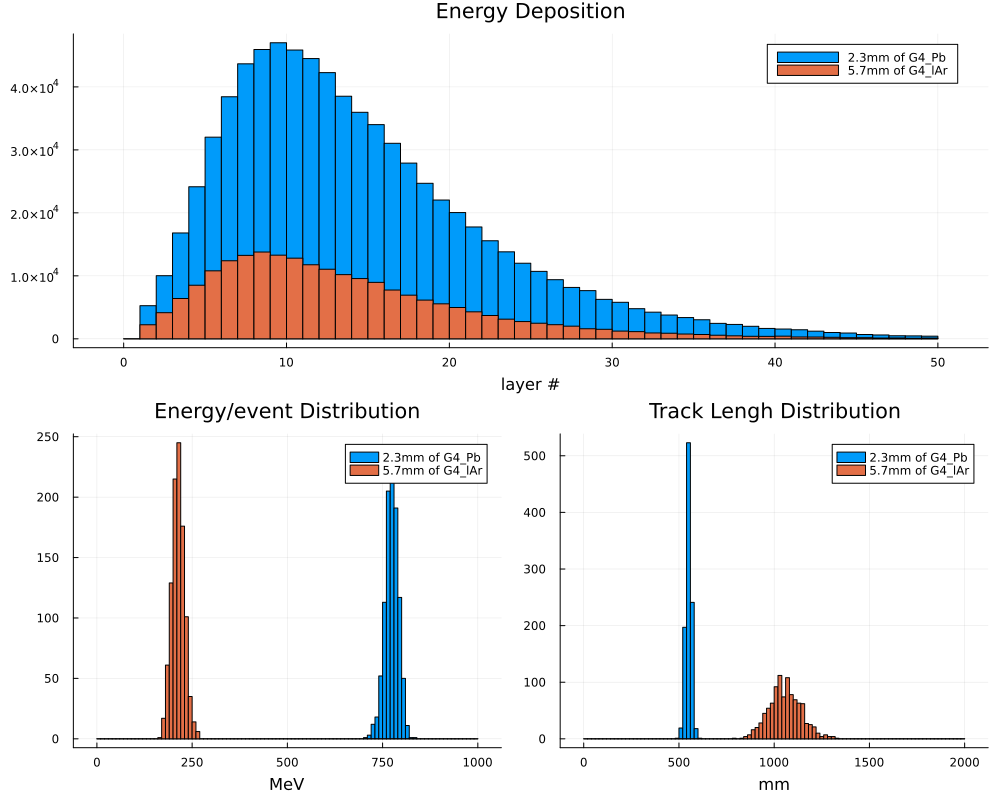

In [8]:
do_plot(app.simdata)

In [9]:
pg = GetGun(app.generator)
SetParticleEnergy(pg, 4GeV)

------------------------------------------------------------
 Beam particle e- E = 4.00 GeV
 Mean number of gamma          2089.70
 Mean number of e-             3594.06
 Mean number of e+             214.79
 Mean number of charged steps  14979.000000
 Mean number of neutral steps  14911.240000
------------------------------------------------------------

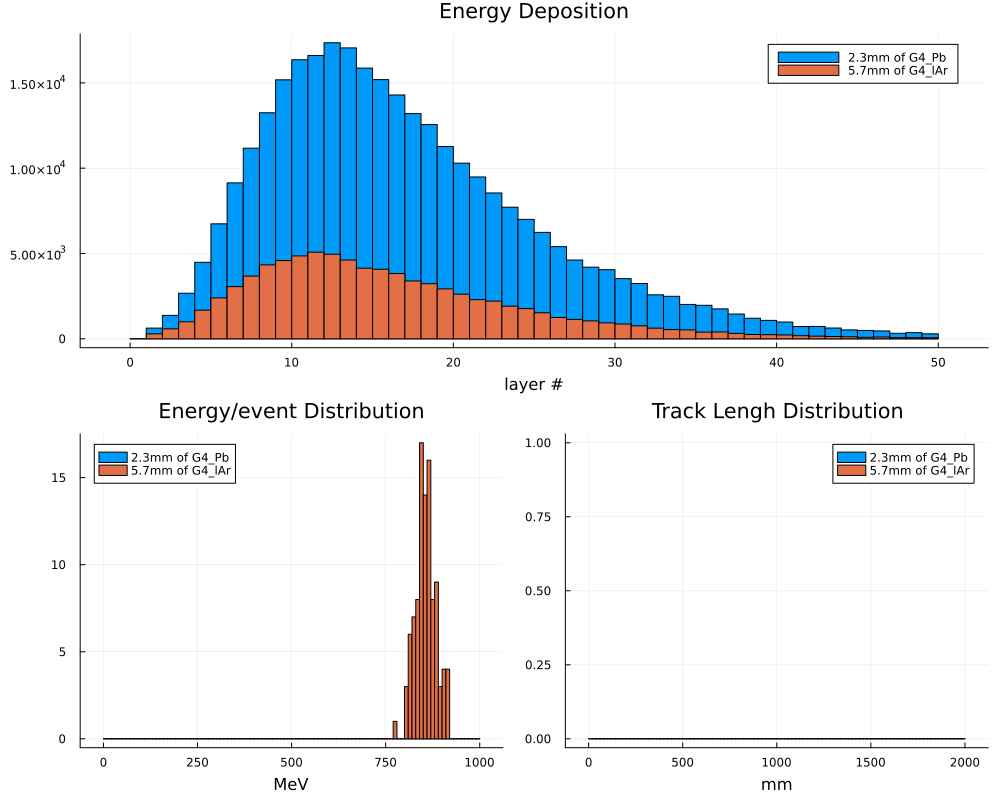

In [10]:
beamOn(app, 100)
do_plot(app.simdata)

In [11]:
reinitialize(app, TestEm3Detector(absorThickness = [2.3mm, 5.7mm, 1mm],
                                   absorMaterial = ["G4_Pb", "G4_lAr", "G4_Al"]))

Building Geometry now!!!


------------------------------------------------------------
 Beam particle e- E = 4.00 GeV
 Mean number of gamma          2024.40
 Mean number of e-             3567.18
 Mean number of e+             207.62
 Mean number of charged steps  16048.770000
 Mean number of neutral steps  19322.620000
------------------------------------------------------------

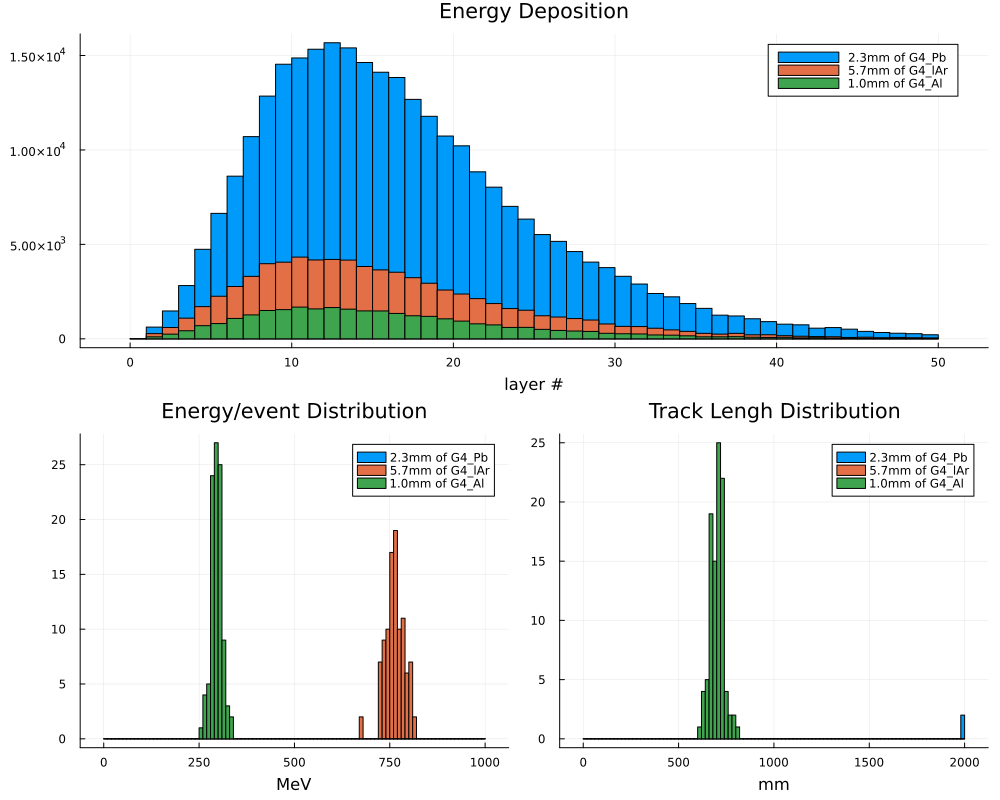

In [12]:
beamOn(app, 100)
do_plot(app.simdata)